<a href="https://colab.research.google.com/github/dnguyend/lagrange_rayleigh/blob/master/NonLinearEigen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\newcommand{\bP}{\boldsymbol{P}}$
$\newcommand{\bL}{\boldsymbol{L}}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bLx}{\boldsymbol{L}_{\bx}}$
$\newcommand{\blbd}{\boldsymbol{\lambda}}$
$\newcommand{\bLlbd}{\boldsymbol{L}_{\blbd}}$
$\newcommand{\Plbd}{\boldsymbol{P}_{\blbd}}$
$\newcommand{\bJC}{\boldsymbol{J}_{\boldsymbol{C}}}$
# The non linear eigenvalue problem#

We show how the frameworks in the paper applies to the non linear eigen value problem. 

Since classical eigenvalue problem is a special case of nonlinear eigenvalue problem, the analysis here works for classical eigenvalue problem.

Much of this result is known, but we want to cast it under the framework of the paper. We do a comparison of Rayleigh Chebyshev versus regular RQI, and two-sided RQI. As expected, because of the extra calculations, Rayleigh Chebyshev underperform two-sided RQI. It outperforms regular RQI. 

A special feature is since $\bL(\bx, \blbd) = \bP(\blbd)\bx$ is linear in $\bx$, it turns out
$$\nu = \bLx^{-1}\bL(\bx, \blbd) = \bx$$.
$$\zeta = \bP^{-1}(\blbd)\Plbd(\blbd)\bx$$
Therefore
$$\bx + \eta = \bx -\bx + \zeta\bJC(\zeta)\bJC(\bx) = \zeta\bJC(\zeta)\bJC(\bx) $$
is proportional to $\zeta$.


In [1]:
!git clone https://github.com/dnguyend/lagrange_rayleigh

Cloning into 'lagrange_rayleigh'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 138 (delta 65), reused 99 (delta 37), pack-reused 0
Receiving objects: 100% (138/138), 1.25 MiB | 22.81 MiB/s, done.
Resolving deltas: 100% (65/65), done.


First we introduce a number of algorithms and support functions. the matrix and its eigenvectors are could all be complex numbers:

In [0]:
from __future__ import print_function

import numpy as np
import time
from numpy import conjugate
from numpy.linalg import solve, norm


def gen_nonlinear_symmetric(n, m):
    # a polynomial matrix of degree m-1
    # [:, :, 0] correspond to highest degree
    # [:, :, m-1] is the constant term
    # symmetric
    mat = np.random.randn(n, n, m)
    for i in range(m):
        mat[:, :, i] = 0.5 * (
            mat[:, :, i] + mat[:, :, i].T)
    return mat


def gen_nonlinear(n, m, hermitian=False):
    # a polynomial matrix of degree m-1
    # [:, :, 0] correspond to highest degree
    # [:, :, m-1] is the constant term
    # symmetric
    mat = np.random.randn(n, n, m) + np.random.randn(n, n, m)*1.j
    if hermitian:
        for i in range(m):
            mat[:, :, i] = 0.5 * (
                mat[:, :, i] + conjugate(mat[:, :, i]).T)
    return mat


def deriv(mat):
    if mat.shape[2] == 1:
        return np.zeros_like(mat)
    ret = np.zeros((
        mat.shape[0], mat.shape[1], mat.shape[2]-1), dtype=mat.dtype)
    for i in range(mat.shape[2]-1):
        ret[:, :, i] = mat[:, :, i] * (mat.shape[2]-1-i)
    return ret


def eval_mat(mat, lbd):
    ret = np.zeros_like(mat[:, :, 0])
    for i in range(mat.shape[2]):
        ret = ret * lbd + mat[:, :, i]
    return ret


def eval_pol(mat, v, w):
    return np.poly1d(
        [conjugate(w) @ (mat[:, :, i] @ v) for i in range(mat.shape[2])])


def rayleigh_chebyshev_linear(
        mat, v0, lbd0, max_itr, tol, u, debug_print=False, do_chebyshev=True):
    """ Works for both real and complex field
    """
    der_mat = deriv(mat)
    der_mat2 = deriv(der_mat)
    lbd = lbd0
    v_k = v0 / (u @ v0)
    for k in range(max_itr):
        err = norm((eval_mat(mat, lbd) @ v_k))
        if err < tol:
            break

        F_lbd = eval_mat(mat, lbd)
        Fp_lbd = eval_mat(der_mat, lbd)
        Fp2_lbd = eval_mat(der_mat2, lbd)
        zeta = solve(F_lbd, (Fp_lbd @ v_k))
        # we do not want the second degree term
        # to dominate so we add it only if norm
        zeta /= (u @ zeta)
        eta = zeta - v_k
        # if False and (norm(eta) < .001):
        if do_chebyshev and (norm(eta < 1e-2)):
            # pdb.set_trace()
            xH_P_lbd_x = np.sum(u * (Fp_lbd @ v_k))
            xPb = u @ (F_lbd @ eta)
            J_R_eta = -xPb / xH_P_lbd_x
            L_x_lbd = (Fp_lbd @ eta) * J_R_eta
            L_lbd_lbd = (Fp2_lbd @ v_k) * (J_R_eta * J_R_eta)
            T_adj = solve(F_lbd, -L_x_lbd - 0.5 * L_lbd_lbd)
            
            v_k_n = zeta + T_adj
            v_k_n /= (u @ v_k_n)
            v_k = v_k_n
            if False:
                v_k_n = zeta
                v_k = v_k_n
        else:
            v_k_n = zeta
            v_k = v_k_n
        rr = np.poly1d(
            [u @ (mat[:, :, i] @ v_k) for i in range(mat.shape[2])]).roots
        lbd = rr[np.argsort(np.abs(rr - lbd))[0]]
        if debug_print:
            print("rr=%s lbd=%s" % (str(rr), str(lbd)))

    return v_k, lbd, k, err < tol


def _rayleigh_chebyshev_trans_not_used(
        mat, v0, lbd0, max_itr, tol, debug_print=False, do_chebyshev=True):
    """mat, v, lbd are all real or complex we use zTz=1 so non compact
    for complex. SHOULD NOT USE
    """
    der_mat = deriv(mat)
    der_mat2 = deriv(der_mat)
    lbd = lbd0
    v_k = v0 / np.sqrt(v0.T @ v0)
    for k in range(max_itr):
        err = norm(eval_mat(mat, lbd) @ v_k)
        if err < tol:
            break

        F_lbd = eval_mat(mat, lbd)
        Fp_lbd = eval_mat(der_mat, lbd)
        Fp2_lbd = eval_mat(der_mat2, lbd)
        zeta = solve(F_lbd, (Fp_lbd @ v_k))
        # we do not want the second degree term
        # to dominate so we add it only if norm
        zeta /= np.sqrt(zeta.T @ zeta)
        eta = zeta - v_k
        if do_chebyshev and (norm(eta) < .01):
            # pdb.set_trace()
            xH_P_lbd_x = np.sum(v_k * (Fp_lbd @ v_k))
            xPb = v_k @ ((F_lbd + F_lbd.T) @ eta)
            J_R_eta = -xPb / xH_P_lbd_x
            L_x_lbd = (Fp_lbd @ eta) * J_R_eta
            L_lbd_lbd = (Fp2_lbd @ v_k) * (J_R_eta * J_R_eta)
            T_adj = solve(F_lbd, -L_x_lbd - 0.5 * L_lbd_lbd)
            if True or (norm(T_adj) < 0.1 * norm(eta)):
                v_k_n = zeta + T_adj
                v_k_n /= np.sqrt(v_k_n.T @ v_k_n)
                v_k = v_k_n
            else:
                v_k_n = zeta
                v_k = v_k_n
        else:
            v_k_n = zeta
            v_k = v_k_n
        rr = np.poly1d(
            [v_k @ (mat[:, :, i] @ v_k) for i in range(mat.shape[2])]).roots
        # rr = eval_pol(mat, v_k, v_k).roots
        lbd = rr[np.argsort(np.abs(rr - lbd))[0]]
        if debug_print:
            print("rr=%s lbd=%s" % (str(rr), str(lbd)))

    return v_k, lbd, k, err < tol
            

def two_sided_schreiber(
        mat, v0, lbd0, max_itr, tol, w0=None, debug_print=False):
    der_mat = deriv(mat)
    lbd = lbd0
    v_k = v0 / norm(v0)
    if w0 is None:
        w0 = v0.T / norm(v0)
    w_k = w0
    for k in range(max_itr):
        err = norm(eval_mat(mat, lbd) @ v_k)
        if err < tol:
            break

        F_lbd = eval_mat(mat, lbd)
        Fp_lbd = eval_mat(der_mat, lbd)
        v_k_n = solve(F_lbd, (Fp_lbd @ v_k))
        v_k_n /= norm(v_k_n)

        w_k_n = solve(
            conjugate(F_lbd).T,
            conjugate(Fp_lbd).T @ w_k)
        w_k_n /= norm(w_k_n)
        v_k = v_k_n
        w_k = w_k_n

        rr = eval_pol(mat, v_k, w_k).roots
        lbd = rr[np.argsort(np.abs(rr - lbd))[0]]
        if debug_print:
            print("rr=%s lbd=%s v_k=%s w_k=%s" % (str(rr), str(lbd), str(v_k), str(w_k)))
    return v_k_n, lbd, k, err < tol


def inverse_iteration(mat, v0, lbd0, max_itr, tol, u):
    """ inverse_iteration
    the constraint set is u @ vt = 1
    return v, lbd, nbr_iter, convergence
    """
    v = v0.copy()
    der_mat = deriv(mat)
    lbd = lbd0
    for k in range(max_itr):
        err = norm(eval_mat(mat, lbd) @ v)
        if err < tol:
            break
        vt = solve(
            eval_mat(mat, lbd), eval_mat(der_mat, lbd)) @ v
        lbd -= (u.T @ v) / (np.sum(u * vt))
        v = vt/norm(vt)
    return v, lbd, k, err < tol


We compare all runs in the following:

sr ii=0 lbd=(0.9433429035751112-0.061986666921747834j) k=6 conv=1
sc ii=0 lbd=(0.8167044437631178-0.6732783815818864j) k=9 conv=1
scb ii=0 lbd=(1.4286704832958583-0.4950528849821565j) k=7 conv=1
sr ii=1 lbd=(0.9433429035751114-0.06198666692174804j) k=5 conv=1
sc ii=1 lbd=(0.9433429035751063-0.0619866669217468j) k=8 conv=1
scb ii=1 lbd=(0.9433429035751215-0.06198666692173842j) k=4 conv=1
sr ii=2 lbd=(0.9433429035751112-0.0619866669217479j) k=5 conv=1
sc ii=2 lbd=(0.9433429035751328-0.06198666692172852j) k=7 conv=1
scb ii=2 lbd=(0.9154334548814698-0.14915189154423203j) k=5 conv=1
sr ii=3 lbd=(0.9433429035751095-0.06198666692174825j) k=5 conv=1
sc ii=3 lbd=(0.5553704522022601-0.5212007153273682j) k=11 conv=1
scb ii=3 lbd=(0.8299850994895788-0.4032607607777108j) k=6 conv=1
sr ii=4 lbd=(0.9433429035751101-0.06198666692174822j) k=5 conv=1
sc ii=4 lbd=(0.7434301332761796+0.2772223100922925j) k=7 conv=1
scb ii=4 lbd=(1.0364920838369902-0.20949445042647374j) k=8 conv=1
sr ii=5 lbd=(1.0582032208

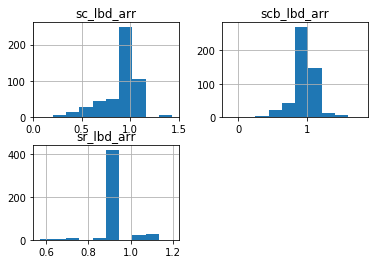

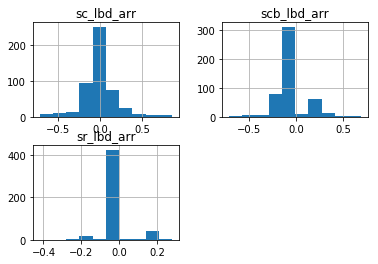

In [4]:

def compare_all():
    tol = 1e-8
    max_itr = 200
    lbd0 = 1+0j
    n = 100
    m = 4
    mat = gen_nonlinear(n, m, hermitian=False)
    u = np.array([1.+0j] + (n-1)*[0.j])
    n_test = 500
    sr_lbd_arr = np.zeros((n_test), dtype=np.complex128)
    sc_lbd_arr = np.zeros((n_test), dtype=np.complex128)
    scb_lbd_arr = np.zeros((n_test), dtype=np.complex128)
    sr_k_arr = np.zeros((n_test), dtype=float)
    sc_k_arr = np.zeros((n_test), dtype=float)
    scb_k_arr = np.zeros((n_test), dtype=float)
    
    sr_conv_arr = np.zeros((n_test), dtype=float)
    sc_conv_arr = np.zeros((n_test), dtype=float)
    scb_conv_arr = np.zeros((n_test), dtype=float)

    sr_time_arr = np.zeros((n_test), dtype=float)
    sc_time_arr = np.zeros((n_test), dtype=float)
    scb_time_arr = np.zeros((n_test), dtype=float)

    sr_err_arr = np.zeros((n_test), dtype=float)
    sc_err_arr = np.zeros((n_test), dtype=float)
    scb_err_arr = np.zeros((n_test), dtype=float)

    for ii in range(n_test):
        v0 = np.random.randn(n) + np.random.randn(n)*1.j
        v0 /= np.sum(u*v0)
        # i_v, i_lbd, i_k, i_conv = inverse_iteration(
        # mat, v0, lbd0, max_itr, tol, u)
        # print("DOING SR")
        t_start = time.time()
        sr_v, sr_lbd, sr_k, sr_conv = two_sided_schreiber(
            mat, v0.copy(), lbd0, max_itr, tol, w0=None, debug_print=False)
        t_end = time.time()
        sr_time_arr[ii] = t_end - t_start
        # print("DOING SC")
        t_start = time.time()
        if True:
            sc_v, sc_lbd, sc_k, sc_conv = rayleigh_chebyshev_linear(
                mat, v0.copy(), lbd0, max_itr, tol,
                u, debug_print=False, do_chebyshev=False)
            """
        else:
            sc_v, sc_lbd, sc_k, sc_conv = rayleigh_chebyshev_trans(
                mat, v0, lbd0, max_itr, tol,
                debug_print=False, do_chebyshev=True)
            """

        t_end = time.time()
        sc_time_arr[ii] = t_end - t_start
        
        t_start = time.time()
        scb_v, scb_lbd, scb_k, scb_conv = rayleigh_chebyshev_linear(
            mat, v0.copy(), lbd0, max_itr, tol,
            u, debug_print=False, do_chebyshev=True)
        t_end = time.time()
        scb_time_arr[ii] = t_end - t_start
        
        sr_lbd_arr[ii] = sr_lbd
        sc_lbd_arr[ii] = sc_lbd
        scb_lbd_arr[ii] = scb_lbd
        
        sr_k_arr[ii] = sr_k
        sc_k_arr[ii] = sc_k
        scb_k_arr[ii] = scb_k
        
        sr_conv_arr[ii] = sr_conv
        sc_conv_arr[ii] = sc_conv
        scb_conv_arr[ii] = scb_conv

        sr_err_arr[ii] = np.linalg.norm(eval_mat(mat, sr_lbd) @ sr_v)
        sc_err_arr[ii] = np.linalg.norm(eval_mat(mat, sc_lbd) @ sc_v)
        scb_err_arr[ii] = np.linalg.norm(eval_mat(mat, scb_lbd) @ scb_v)
        
        print("sr ii=%d lbd=%s k=%d conv=%d" % (
            ii, str(sr_lbd), sr_k, sr_conv))
        print("sc ii=%d lbd=%s k=%d conv=%d" % (
            ii, str(sc_lbd), sc_k, sc_conv))
        print("scb ii=%d lbd=%s k=%d conv=%d" % (
            ii, str(scb_lbd), scb_k, scb_conv))

    import pandas as pd
    pdF = pd.DataFrame({'sr_lbd_arr': sr_lbd_arr,
                        'sc_lbd_arr': sc_lbd_arr,
                        'scb_lbd_arr': scb_lbd_arr,
                        'sr_k_arr': sr_k_arr,
                        'sc_k_arr': sc_k_arr,
                        'scb_k_arr': scb_k_arr,
                        'sr_conv_arr': sr_conv_arr,
                        'sc_conv_arr': sc_conv_arr,
                        'scb_conv_arr': scb_conv_arr,
                        
                        'sr_time_arr': sr_time_arr,
                        'sc_time_arr': sc_time_arr,
                        'scb_time_arr': scb_time_arr,

                        'sr_err_arr': sr_err_arr,
                        'sc_err_arr': sc_err_arr,
                        'scb_err_arr': scb_err_arr},
                       columns=['sr_lbd_arr',
                                'sc_lbd_arr',
                                'scb_lbd_arr',
                                'sr_k_arr',
                                'sc_k_arr',
                                'scb_k_arr',
                                'sr_conv_arr',
                                'sc_conv_arr',
                                'scb_conv_arr',
                                'sr_time_arr',
                                'sc_time_arr',
                                'scb_time_arr',
                                'sr_err_arr',
                                'sc_err_arr',
                                'scb_err_arr'])
    print(pdF[[a for a in pdF.columns if '_k_' in a]].describe())
    print(pdF[[a for a in pdF.columns if '_time_' in a]].describe())
    print(pdF[[a for a in pdF.columns if '_lbd_' in a]].apply(
        np.real, axis=0).describe())
    print(pdF[[a for a in pdF.columns if '_lbd_' in a]].apply(
        np.imag, axis=0).describe())
    print(pdF[[a for a in pdF.columns if '_err_' in a]].describe())

    pdF[[a for a in pdF.columns if '_lbd_' in a]].apply(np.real, axis=0).hist()
    pdF[[a for a in pdF.columns if '_lbd_' in a]].apply(np.imag, axis=0).hist()
    return pdF
    
def check_eigen(mat, lbd, v):
    return eval_mat(mat, lbd) @ v, norm(eval_mat(mat, lbd) @ v)


def check_deriv(mat, lbd):
    dd = deriv(mat)
    h = 1e-5
    print((eval_mat(mat, lbd+h) - eval_mat(mat, lbd))/h-eval_mat(dd, lbd))



pdF = compare_all()

In [5]:
pdF.describe()

,sr_lbd_arr,sc_lbd_arr,scb_lbd_arr,sr_k_arr,sc_k_arr,scb_k_arr,sr_conv_arr,sc_conv_arr,scb_conv_arr,sr_time_arr,sc_time_arr,scb_time_arr,sr_err_arr,sc_err_arr,scb_err_arr
count,(500+0j),(500+0j),(500+0j),500.000000,500.000000,500.000000,500.0,500.0,500.0,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,(0.9454078677563117-0.04551380221201718j),(0.8916982350415611-0.02873139249182711j),(0.9534902215304613-0.053474511400243j),5.440000,9.062000,5.720000,1.0,1.0,1.0,0.017428,0.024496,0.020807,4.508447e-10,6.237234e-10,4.157590e-10
std,(0.0985765274573385+0j),(0.27518146872830235+0j),(0.23157877118383025+0j),1.176933,2.210867,1.386161,0.0,0.0,0.0,0.005386,0.008487,0.007522,1.506566e-09,1.609424e-09,1.325885e-09
min,(0.569152653989528+0.12363164654205451j),(0.06871389386778284+0.01810412090690429j),(-0.13738684895496872+0.3174870572108329j),4.000000,5.000000,3.000000,1.0,1.0,1.0,0.010098,0.011714,0.009220,3.351361e-14,2.175588e-13,1.714604e-13
25%,(0.9433429035751102-0.06198666692174817j),(0.8347432209035539+0.15463087235726886j),(0.9164388992148994+0.1814555090594699j),5.000000,7.000000,5.000000,1.0,1.0,1.0,0.013801,0.018427,0.015299,5.888858e-14,8.398791e-13,7.228035e-13
50%,(0.943342903575111-0.06198666692174812j),(0.9433429035751064-0.061986666921746966j),(0.943342903575112-0.06198666692174945j),5.000000,9.000000,6.000000,1.0,1.0,1.0,0.016364,0.022387,0.018885,7.553821e-14,2.686553e-12,1.409562e-12
75%,(0.9433429035751116-0.06198666692174884j),(0.9433429035822748-0.06198666693425757j),(1.0582032207996783+0.14550386686274944j),6.000000,10.000000,6.000000,1.0,1.0,1.0,0.019071,0.027989,0.023747,1.052182e-11,1.932154e-10,1.641834e-11
max,(1.1963663271672798+0.24790590631302645j),(1.4286704832959418-0.49505288498211664j),(1.7785516855555492-0.3745587505597521j),11.000000,18.000000,11.000000,1.0,1.0,1.0,0.056507,0.082285,0.066353,9.831600e-09,9.735094e-09,9.438456e-09


The result shows Rayleigh Chebyshev underperforms two-sided RQI, but outperform regular RQI.